<small>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones, FaMAF UNC, 2021.</small>
# Aprendizaje no Supervisado 

Este trabajo pertenece a la mentoría **GAP: Gestión Automática de Pedidos de Combustibles Líquidos basada en telemetría de inventarios**.

Integrantes:
- Bernaschini, María Laura
- Bosch, Daniela
- Sanabria, Ángel

## Introducción

En este trabajo se busca generalizar el modelo planteado en el trabajo anterior (Aprendizaje Supervisado) para todos los centros operativos-productos. Para esto realizamos un aglomeramiento (clustering) de estos centros para encontrar patrones similares entre ellos y poder determinar a futuro los mejores parámetros por grupo que permitan generalizar el modelo de predicción.

In [ ]:
!pip install tslearn
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score

seaborn.set_context('talk')
# Set float format
pd.set_option('display.float_format','{:.5f}'.format)
pd.set_option('mode.chained_assignment', None)

# Set style
seaborn.set_style("darkgrid")
seaborn.set_palette('pastel')
seaborn.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12}) 

## Lectura del dataset

Levantamos el pickle generado en los trabajos anteriores.

In [ ]:
def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_pkl_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_pickle(filename)

def read_csv_from_drive(drive, id, filename, usecols, parse_dates, dtypes):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(
        filename, 
        dtype=dtypes, 
        parse_dates=parse_dates,
        usecols=usecols
    )

drive_connection = connect_to_drive()

In [ ]:
# pkl_key2 = '1SztUxzHZjf1mmNRC77KmJ2p33urOxibT'
pkl_key2 = '11ihPPpzsS_9R5Kb--ZQNuDjFTzYkgc4C'
# df = read_pkl_from_drive(drive_connection, pkl_key2, 'df_curated_per_hour.pkl')
df = read_pkl_from_drive(drive_connection, pkl_key2, 'curated_df.pkl')
df.head()

,id_equipo,nombre_producto,capacidad,volumen,consumo,industria,volumen_escl,consumo_escl,equipo_producto
timestamp,,,,,,,,,
2021-01-01 00:00:00,477,VP Nafta,15032.00000,865.65002,0.00000,Service Station,0.05759,0.00000,477-VP Nafta
2021-01-01 00:05:00,477,VP Nafta,15032.00000,865.65002,0.00000,Service Station,0.05759,0.00000,477-VP Nafta
2021-01-01 00:10:00,477,VP Nafta,15032.00000,865.65002,0.00000,Service Station,0.05759,0.00000,477-VP Nafta
2021-01-01 00:15:00,477,VP Nafta,15032.00000,865.65002,0.00000,Service Station,0.05759,0.00000,477-VP Nafta
2021-01-01 00:20:00,477,VP Nafta,15032.00000,864.98401,0.16650,Service Station,0.05754,0.00001,477-VP Nafta


In [ ]:
df = df.sort_index()

## Clustering

### 1. Clustering observando el comportamiento del volúmen

Para este análisis se harán agrupamientos de acuerdo al movimiento que se observa sobre el combustible en cada centro operativo-producto. Para ésto se utilizará la librería de `tslearn`, wrapper de `sklearn` para series temporales.

Tomamos las últimas dos semanas del dataset original.

In [ ]:
df_one_week = df[df.index >= '2021-03-24']

Realizamos un pivoteo del dataset por el centro operativo-producto en lugar de utilizar `groupby` como se hacía anteriormente, ya que los modelos a utilizar trabajan correctamente con estos objetos. De no realizar un agrupamiento previo, se estarían clusterizando segmentos de series de tiempo en lugar de centros operativos-productos.

In [ ]:
df_pivot = df_one_week.pivot(
    columns="equipo_producto", 
    values="volumen_escl"
).dropna(axis=0)
df_pivot.head()

equipo_producto,159-Formula Diesel,159-Nafta Super,159-V-Power Diesel,159-V-Power Nafta,210-Euro 5,220-Product 1,227-Gas Oil,248-D500,248-Infinia Diesel,248-Infinia Nafta,346-Infinia Diesel,346-Ultra Diesel,357-Formula,357-Super,357-VP-Diesel,357-VP-Nafta,421-Diesel,429-Formula Diesel,429-Nafta Super,429-Nafta V-Power,429-V-Power Nitro,431-Product 1,433-DIESEL,439-Producto 0,441-Infinia Diésel,453-Diesel 500,455-Diesel,459-Gasoil,477-Formula Diesel,477-VP Nafta,479-Diesel,479-Urea,480-Formula,484-S1002050010,486-Diesel 500,486-Infinia Diesel,486-Infinia Nafta,486-Nafta Super,495-Formula Diesel,495-Nafta Super,...,770-Diesel,771-Diesel,783-Diesel,788-Product 2,794-Gas Oil,799-Diesel,799-Quantum Diesel,799-Quantum Nafta,799-Super,800-Diesel,800-Euro,800-Premium,801-Product 1,806-Euro,816-Producto 0,827-B100,828-B100,830-B100,831-Diesel,838-Diesel 500,838-Euro Diesel,841-Formula Diesel,841-VP Nafta,842-Diesel,849-Diesel 500,851-Diesel 500,853-Diesel,854-Diesel,867-Diesel 500,869-Diesel,871-Diesel 500,874-Aceite,874-Diesel 500,887-Diesel 500,890-Diesel,900-Formula Diesel,900-Nafta Super,900-VP Diesel,900-VP Nafta,958-BIO
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-24 00:00:00,0.16275,0.20222,0.21949,0.32014,0.17229,0.36425,0.32228,0.63983,0.38797,0.62130,0.71428,0.61141,0.58604,0.32861,0.46854,0.53679,0.86794,0.64317,0.37213,0.33857,0.39142,0.67814,0.25489,0.70492,0.59837,0.08656,0.20919,0.22588,0.43491,0.45794,0.94806,0.62718,0.72688,0.58390,0.32111,0.33550,0.67275,0.40217,0.18306,0.39090,...,0.84200,0.88640,0.84372,0.35573,0.33417,0.63747,0.79625,0.55841,0.85840,0.49746,0.27227,0.41949,0.04503,0.24186,0.27954,0.96619,0.04562,0.91149,0.63880,0.69220,0.39321,0.41000,0.19573,0.35221,0.48814,0.42102,0.68605,0.59248,0.75385,0.72361,0.71100,0.12278,0.24500,0.33382,0.11923,0.45282,0.80928,0.65188,0.54546,0.25349
2021-03-24 00:05:00,0.16275,0.20183,0.21868,0.31970,0.17229,0.36077,0.32228,0.63963,0.38518,0.61938,0.71428,0.61136,0.58604,0.32831,0.46854,0.53635,0.86786,0.64317,0.37180,0.33857,0.39142,0.67805,0.25470,0.70492,0.59832,0.08526,0.20928,0.22580,0.43491,0.45748,0.94800,0.62586,0.72683,0.58390,0.32049,0.33548,0.67270,0.40214,0.18312,0.38921,...,0.84200,0.88620,0.84372,0.35573,0.33412,0.63747,0.79630,0.55835,0.85835,0.49746,0.27227,0.41971,0.04501,0.24186,0.27954,0.96619,0.04562,0.91149,0.63878,0.69213,0.39321,0.40813,0.19573,0.35216,0.48814,0.42102,0.68537,0.59064,0.75376,0.72361,0.71089,0.12278,0.24498,0.33382,0.11920,0.45282,0.80765,0.65188,0.54562,0.25349
2021-03-24 00:10:00,0.16275,0.20119,0.21868,0.31970,0.17229,0.36077,0.32228,0.63963,0.38518,0.61920,0.71428,0.61136,0.58257,0.32831,0.46854,0.53635,0.86786,0.64317,0.37180,0.33857,0.39142,0.67805,0.25470,0.70492,0.59832,0.08371,0.20928,0.22580,0.43480,0.45647,0.94800,0.62586,0.72683,0.58390,0.32049,0.33548,0.67270,0.40183,0.18312,0.38880,...,0.84200,0.88620,0.84372,0.35573,0.33412,0.63747,0.79630,0.55835,0.85835,0.49746,0.27227,0.41971,0.04501,0.24186,0.27954,0.96619,0.04562,0.91149,0.63878,0.69213,0.39321,0.40813,0.19573,0.35216,0.48814,0.42102,0.68537,0.59064,0.75376,0.72361,0.71089,0.12278,0.24498,0.33382,0.11920,0.45283,0.80795,0.65188,0.54570,0.25349
2021-03-24 00:15:00,0.16275,0.20119,0.21842,0.31839,0.17082,0.36077,0.32228,0.63963,0.37905,0.61920,0.71428,0.61136,0.57852,0.32831,0.46854,0.53635,0.86786,0.64317,0.37180,0.33857,0.39142,0.67805,0.25470,0.70487,0.59832,0.08371,0.20928,0.22580,0.43480,0.45647,0.94800,0.62586,0.72683,0.58390,0.32008,0.33548,0.67270,0.40164,0.18312,0.38856,...,0.84200,0.88620,0.84372,0.35573,0.33412,0.63747,0.79630,0.55835,0.85835,0.49746,0.27227,0.41971,0.04501,0.24186,0.27954,0.96619,0.04562,0.91149,0.63878,0.69213,0.39321,0.40813,0.19573,0.35216,0.48814,0.42102,0.68537,0.59064,0.75376,0.72361,0.71089,0.12278,0.24498,0.33382,0.11920,0.45280,0.80800,0.65188,0.54313,0.25349
2021-03-24 00:20:00,0.16275,0.20119,0.21817,0.31839,0.17082,0.36077,0.32228,0.63963,0.37070,0.61867,0.71428,0.61136,0.

Definimos algunas funciones auxiliares.

In [ ]:
def plot_clusters(model, n_clusters):
    """Grafica las series de los distintos clusters
    junto con los centros de cada agrupamiento.
    """

    # Centros de los clusters, creamos un DataFrame para utilizar el mismo
    # ínice de nuestro DataFrame pivot.
    df_clusters = pd.DataFrame(df_pivot.index)
    for cluster in range(n_clusters):
        df_clusters[f'cluster_centers_{cluster}'] = model.cluster_centers_[cluster]
    df_clusters.set_index('timestamp', inplace=True)
        
    # Plot!
    for yi in range(n_clusters):
        plt.figure(figsize=(15, 2))
        c = numpy.where(model.labels_ == yi) 
        plt.plot(df_pivot[df_pivot.columns[c]], "g-", alpha=.15)
        plt.plot(df_clusters[f'cluster_centers_{yi}'], "r-")
        plt.ylim(0, 1)
        
        plt.title(f"Cluster {yi}")
        plt.show()

### Modelo KMeans con distancia euclídea como métrica

Utilizamos el modelo de vecinos más cercanos observando la distancia euclídea entre los puntos en el mismo lapso de tiempo. Nuestros datos ya se encuentran escalados, por lo tanto, no es necesario escalarlos nuevamente.

In [ ]:
scores = []
inertia = []
for n_clusters in range(3, 10):
    kmeans_model = TimeSeriesKMeans(
        n_clusters=n_clusters, 
        n_init=10,
        n_jobs=-1,
        random_state=101,
        metric="euclidean",
        max_iter=50
    )
    kmeans_model.fit(df_pivot.T)
    scores.append(silhouette_score(df_pivot.T, kmeans_model.labels_, metric="euclidean"))
    inertia.append(kmeans_model.inertia_)

Veamos la suma de las distancias de las muestras al centro del cluster más próximo.

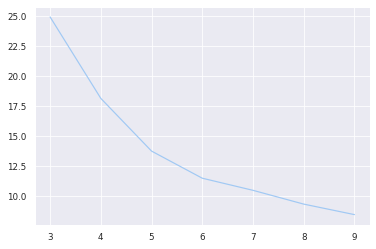

In [ ]:
seaborn.lineplot(x=range(3, 10), y=inertia)

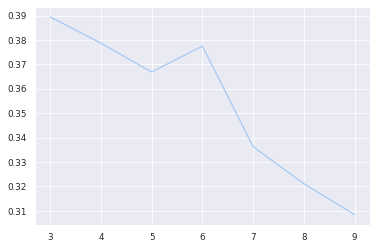

In [ ]:
seaborn.lineplot(x=range(3, 10), y=scores)

De acuerdo a lo observado en los gráficos, se determina que el mejor número de clusters es 6. Ejecutamos el modelo para generar 6 clusters.

In [ ]:
kmeans_model = TimeSeriesKMeans(
    n_clusters=6, 
    verbose=1, 
    n_jobs=-1,
    n_init=10, 
    metric="euclidean",
    max_iter=50,
    random_state=101
)
kmeans_model.fit(df_pivot.T)

Init 1
16.799 --> 12.113 --> 11.649 --> 11.506 --> 11.497 --> 11.497 --> 
Init 2
15.803 --> 12.381 --> 12.231 --> 12.231 --> 
Init 3
19.630 --> 14.652 --> 13.406 --> 12.889 --> 12.704 --> 12.609 --> 12.525 --> 12.508 --> 12.508 --> 
Init 4
15.889 --> 12.643 --> 12.012 --> 11.953 --> 11.847 --> 11.754 --> 11.664 --> 11.577 --> 11.532 --> 11.515 --> 11.502 --> 11.502 --> 
Init 5
18.691 --> 14.108 --> 12.929 --> 12.356 --> 11.802 --> 11.679 --> 11.647 --> 11.587 --> 11.533 --> 11.517 --> 11.512 --> 11.512 --> 
Init 6
16.999 --> 12.339 --> 11.853 --> 11.736 --> 11.685 --> 11.685 --> 
Init 7
14.027 --> 11.889 --> 11.556 --> 11.502 --> 11.502 --> 
Init 8
18.396 --> 14.165 --> 13.693 --> 13.413 --> 13.158 --> 12.977 --> 12.763 --> 12.645 --> 12.628 --> 12.628 --> 
Init 9
14.839 --> 12.630 --> 12.068 --> 11.935 --> 11.785 --> 11.724 --> 11.613 --> 11.544 --> 11.506 --> 11.502 --> 11.502 --> 
Init 10
16.724 --> 13.274 --> 12.874 --> 12.699 --> 12.533 --> 12.504 --> 12.504 --> 


TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=50,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=6, n_init=10, n_jobs=-1,
                 random_state=101, tol=1e-06, verbose=1)

In [ ]:
silhouette_score(df_pivot.T, kmeans_model.labels_, metric="euclidean")

0.37749939308818514

Text(0.5, 1.0, 'Cantidad de centros por cluster Kmeans, euclídea')

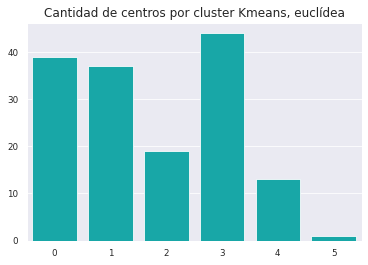

In [ ]:
x, y = numpy.unique(kmeans_model.labels_, return_counts=True)
seaborn.barplot(x=x, y=y, color="c")
plt.title("Cantidad de centros por cluster Kmeans, euclídea")

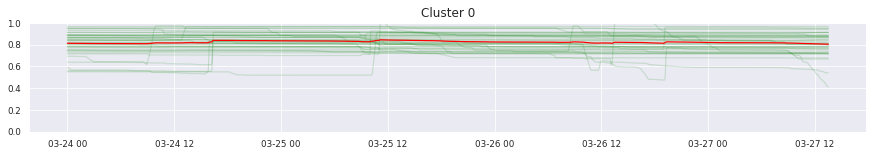

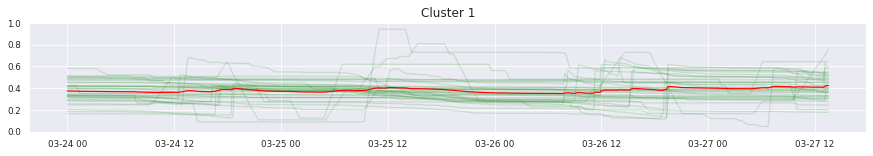

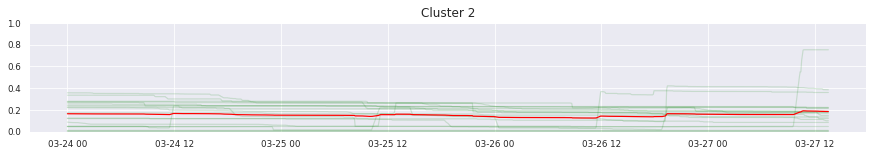

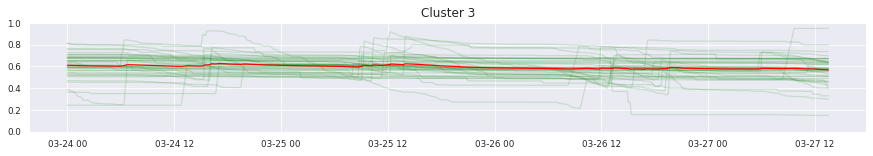

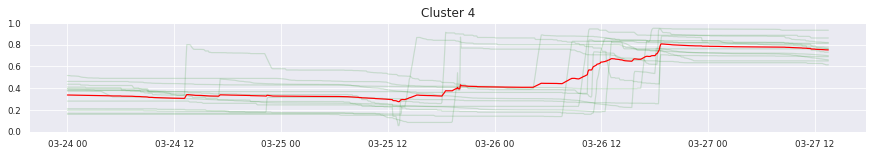

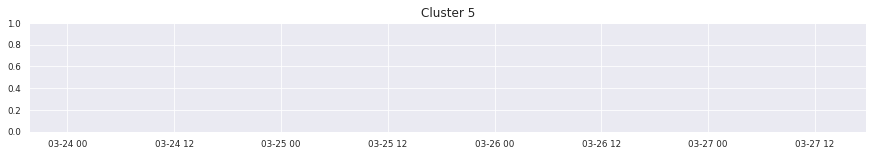

In [ ]:
plot_clusters(kmeans_model, 6)

#### Observaciones

- Se puede observar un agrupamiento por los niveles en que se encuentra normalmente un centro y aquellos centros con variablidad en el volúmen.
- Los centros del **cluster 0** parecen mantenerse siempre en niveles cercanos a su capacidad. A este grupo sería interesante ofrecerles combustible cuando sus niveles bajen del 70% de su capacidad.
- El **cluster 1** parece agrupar aquellos centros con variabilidad en el volúmen pero que en promedio se encuentran por debajo de la mitad de su capacidad. Se observan muchas cargas y descargas. Sería interesante ofrecerles combustible cuando sus tanques estén casi vacíos (menos de un 30%).
- Los centros del **cluster 2** se mantienen siempre en niveles muy bajos o están vacíos. No parecen alcanzar nunca los niveles de la capacidad, quizás pueda ser conveniente ofrecerles cargas no tan grandes.
- El **cluster 3** agrupa centros con variabilidad en el volúmen pero que en promedio se encuentran por encima de la mitad de su capacidad. Se observan muchas cargas y descargas. Sería interesante ofrecerles combustible cuando sus tanques bajen del 50% del nivel de la capacidad.
- Los centros del **cluster 4** realizan cargas de combustible en grandes cantidades y en muy pocas veces. Para este grupo sería conveniente el envío grandes cantidades de combustible, posiblemente camión cisterna completo.

### Modelo KMeans con distancia Dynamic Time Warping como métrica

Aplicamos el modelo de KMeans pero utilizando Dynamic Time Warping como métrica. Nos permite detectar comportamientos similares entre las series pero haciendo que el desplazamiento y la magnitud de los movimientos sean invariantes a diferencia de la distancia euclídea. 

In [ ]:
%%time
# Warning: Slow!
kmeans_dtw_model = TimeSeriesKMeans(
    n_clusters=6, 
    verbose=1,
    n_jobs=-1, 
    n_init=2, 
    metric="dtw",
    max_iter=5,
    max_iter_barycenter=10,
    random_state=101
)
kmeans_dtw_model.fit(df_pivot.T)

Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  

11.751 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:   31.3s finished


3.116 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:   31.4s finished


3.026 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:   31.5s finished


2.977 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:   30.7s finished


2.960 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 459 out of 459 | elapsed:   15.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  

12.568 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:   30.9s finished


3.179 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:   32.1s finished


2.396 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:   31.9s finished


2.257 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:   31.5s finished


2.236 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   27.7s


CPU times: user 32min 6s, sys: 1min 30s, total: 33min 37s
Wall time: 23min 57s


[Parallel(n_jobs=-1)]: Done 918 out of 918 | elapsed:   32.0s finished


In [ ]:
silhouette_score(df_pivot.T, kmeans_dtw_model.labels_, metric="dtw") 

0.34032596447507724

Text(0.5, 1.0, 'Cantidad de centros por cluster con Kmeans, DTW')

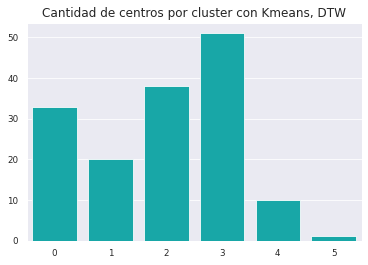

In [ ]:
x, y = numpy.unique(kmeans_dtw_model.labels_, return_counts=True)
seaborn.barplot(x=x, y=y, color="c")
plt.title("Cantidad de centros por cluster con Kmeans, DTW")

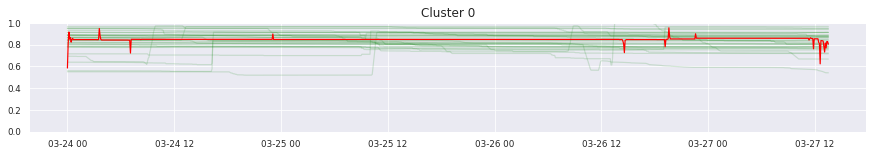

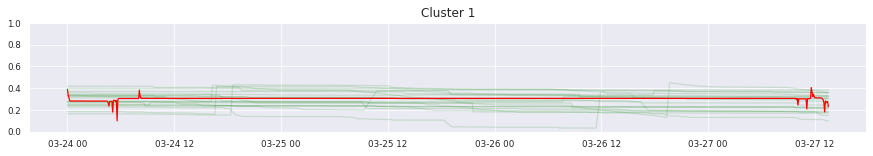

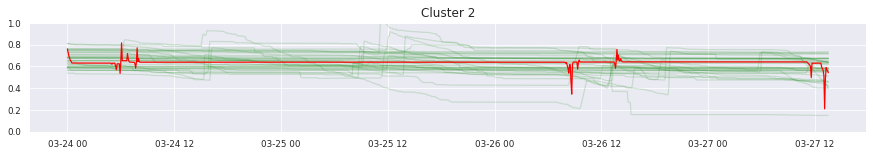

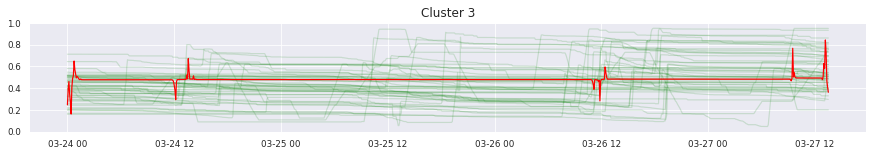

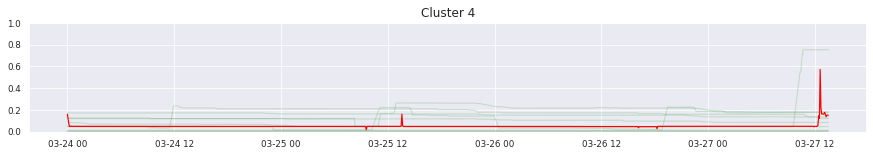

In [ ]:
plot_clusters(kmeans_dtw_model, 5)

#### Observaciones
- No parecen agruparse mejor los centros con esta métrica. Puede deberse a que los comportamientos suelen ser similares en los mismos lapsos de tiempo (turnos, día de la semana, etc.).

### 2. Clustering observando todos los features

Realizamos el agrupamiento teniendo en cuenta los features de `capacidad`, `volumen` y `consumo`.

In [ ]:
features=df_one_week[["capacidad", "volumen", "consumo"]] ##Empleando tres features

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler() ## Se estandarizan las features

In [ ]:
features=scaler.fit_transform(features)

In [ ]:
features

array([[ 0.06388789, -0.4136099 , -0.06950781],
       [ 0.5940132 ,  0.6051916 , -0.09234457],
       [ 0.5940132 , -0.5277436 ,  0.07211408],
       ...,
       [-0.40374902, -0.5707475 , -0.05810804],
       [-0.23983094,  0.2252857 , -0.09234457],
       [ 0.37821147,  0.25315785,  0.809383  ]], dtype=float32)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

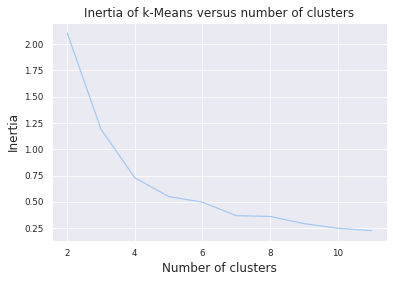

In [ ]:
scores = [TimeSeriesKMeans(n_clusters=i).fit(features).inertia_ for i in range(2,12)]

plt.plot(numpy.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

A partir del gráfico de codo podemos observar que el número óptimo de clusters es 4. A continuación se ajustara el modelo de Kmeans para time series con este número de clusters.

In [ ]:
n_clust = 4

km = TimeSeriesKMeans(n_clusters=n_clust, random_state=10)
km.fit(features) 

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  0.728082161537822


In [ ]:
silhouette_score(features, km.labels_) 

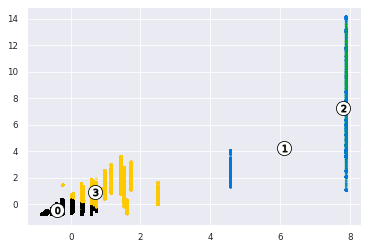

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

clusterer = TimeSeriesKMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(features)
colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
plt.scatter(features[:, 0],features[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

Este gráfico nos permite observar la distribución de los clusters en el espacio de las variables capacidad y volumen. Podemos ver que el cluster 3 es el más variable ya que se superpone con el cluster 2.

In [ ]:
df_one_week['kmeans'] = km.labels_.astype(str) #clusters

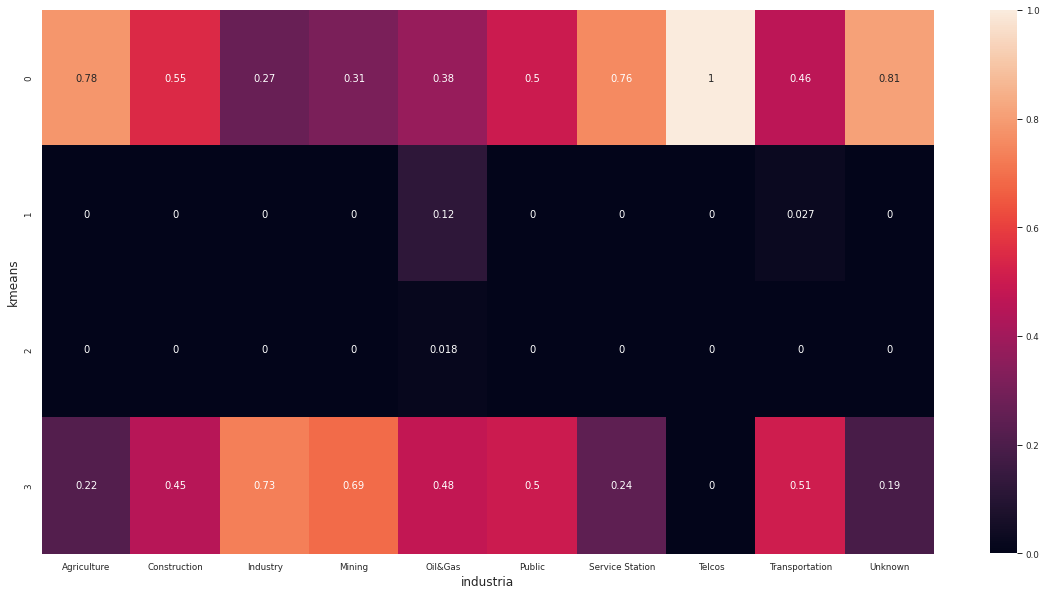

In [ ]:
plt.figure(figsize=(20,10))
seaborn.heatmap(pd.crosstab(df_one_week.kmeans, df_one_week.industria, normalize='columns'),annot=True)

El análisis de tabla cruzada (crosstab) no muestra una asociación fuerte entre los clusters y el tipo de industria. Sin embargo, podemos observar que la industria de telecomunicaciones se asocia al cluster 0 (proporción igual a 1).

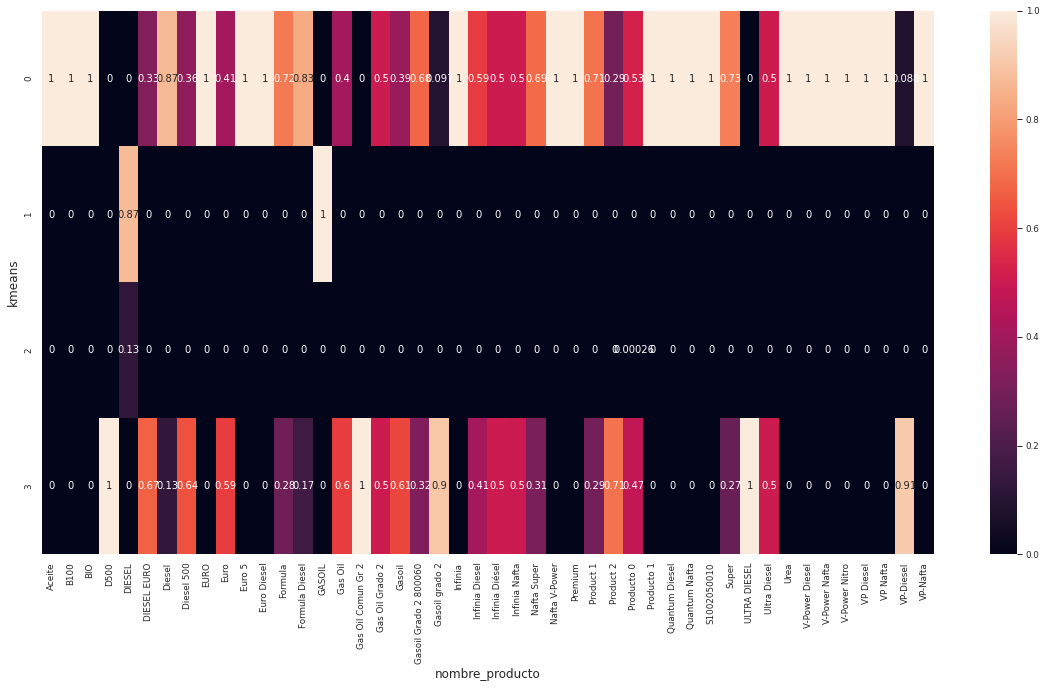

In [ ]:
plt.figure(figsize=(20,10))
seaborn.heatmap(pd.crosstab(df_one_week.kmeans, df_one_week.nombre_producto, normalize='columns'),annot=True)

En este caso, la crosstab muestra una asociación bastante clara entre los clusters y el tipo de producto, evidenciada por las proporciones altas de cada uno de ellos en los determinados clusters (representada por el color claro en el gráfico).

In [ ]:
features=df_one_week[["volumen"]] ## Una sola feature

In [ ]:
scaler=StandardScaler()

In [ ]:
features=scaler.fit_transform(features)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

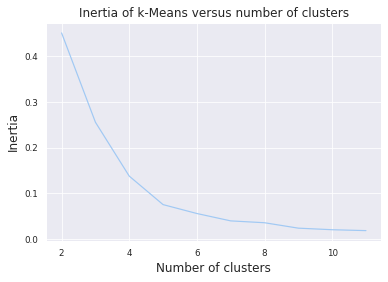

In [ ]:
scores = [TimeSeriesKMeans(n_clusters=i).fit(features).inertia_ for i in range(2,12)]

plt.plot(numpy.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Teniendo en cuenta como features solo al volumen podemos observar que el gráfico de codo identifica al 5 como número de clusters óptimos.

In [ ]:
n_clust = 5

km = TimeSeriesKMeans(n_clusters=n_clust, random_state=10)
km.fit(features) 

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  0.07563095372253638


In [ ]:
silhouette_score(features, km.labels_) 

In [ ]:
df_one_week=df_one_week.reset_index()

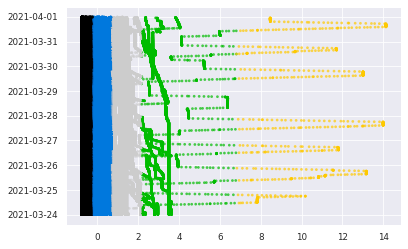

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

clusterer = TimeSeriesKMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(features)
colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
plt.scatter(features[:, 0], df_one_week.loc[:, "timestamp"], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
# plt.scatter(centers[:, 0].ravel(), centers[:, 1].ravel(), marker='o',c="white", alpha=1, s=200, edgecolor='k')

# for i, c in enumerate(centers):
#     plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

In [ ]:
df_one_week['kmeans_v'] = km.labels_.astype(str) #clusters

In [ ]:
df_one_week.kmeans_v.value_counts()

0    181799
1    109702
4     49008
2      9220
3       790
Name: kmeans_v, dtype: int64

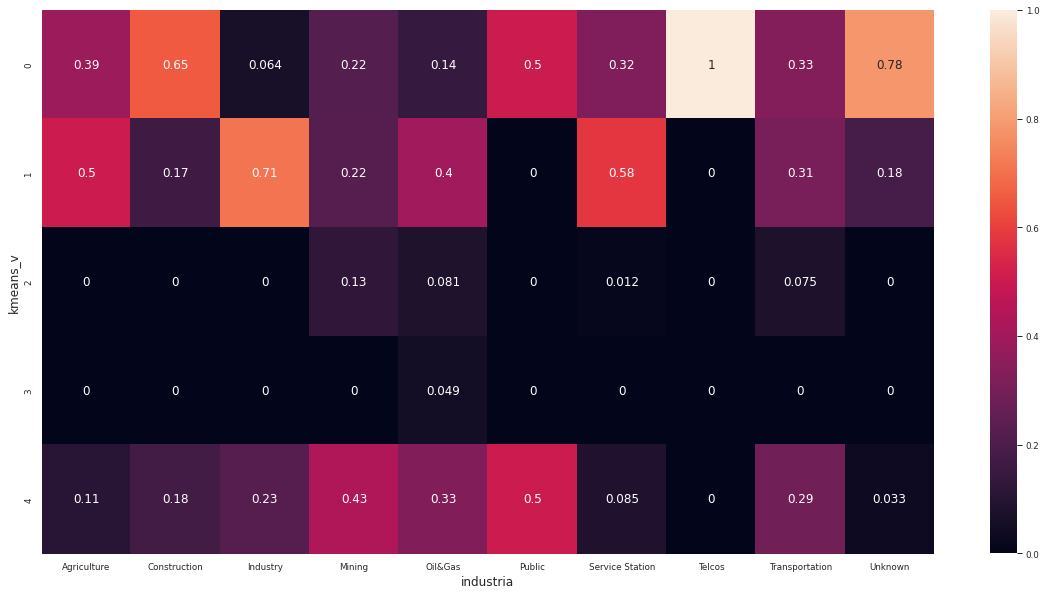

In [ ]:
plt.figure(figsize=(20,10))
seaborn.heatmap(pd.crosstab(df_one_week.kmeans_v, df_one_week.industria, normalize='columns'),annot=True)

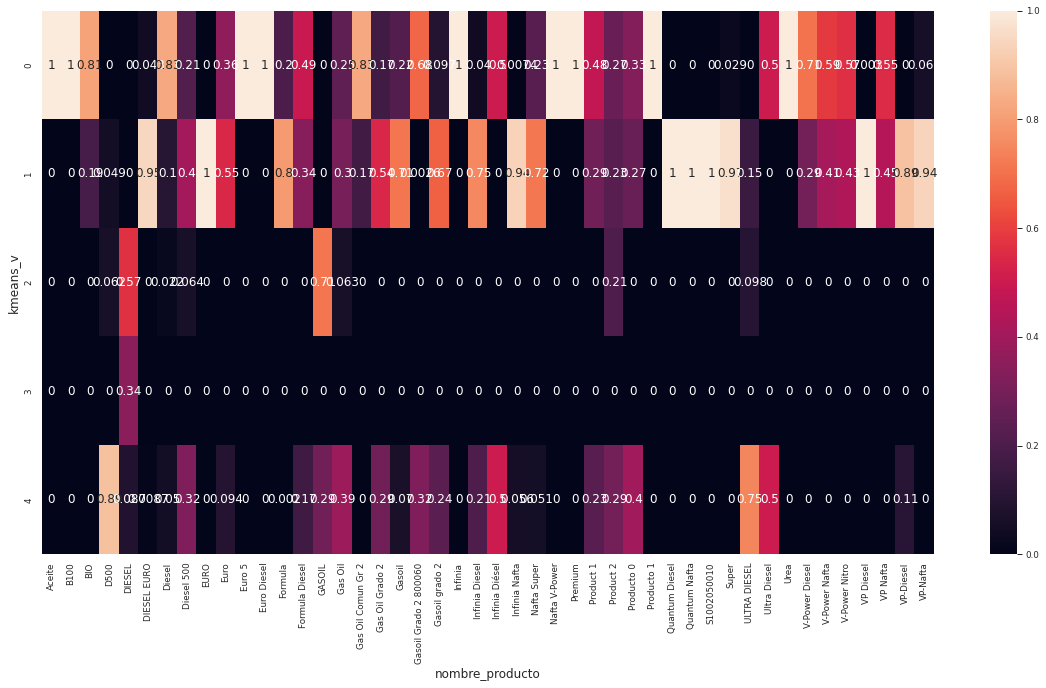

In [ ]:
plt.figure(figsize=(20,10))
seaborn.heatmap(pd.crosstab(df_one_week.kmeans_v, df_one_week.nombre_producto, normalize='columns'),annot=True)

## Conclusiones

Se observaron agrupamientos interesantes de los centros sobre el comportamiento de las series. Estos resultados nos permiten responder o replantear algunas preguntas abiertas de los trabajos anteriores:

- **Se va a implementar una predicción de algún momento deseado, o se hará una predicción continua en el tiempo, o se hará una predicción de tiempo en el que habría cierto volumen de inventario?**
Según lo observado, no todos los centros realizan cargas cuando los niveles son muy bajos, algunos de ellos lo hacen periódicamente o cuando llegan a un porcentaje. Podrían utilizarse ambas estrategias (predicción de momento para cierto volumen, predicción de volumen en un momento) según el sitio.
- **Se va a implementar UN MODELO POR CENTRO OPERATIVO o UN MODELO PARA TODOS LOS CENTROS OPERATIVOS CON HIPERPARÁMETROS?**
Luego de las observaciones, pueden definirse algunos parámetros por defecto para ciertos comportamientos.

Como trabajo a futuro se pretende generalizar el modelo del trabajo anterior para todos los centros operativos.